In [ ]:
# coding: utf-8

In [1]:
"""
CS579: Assignment 0
Collecting a political social network
In this assignment, I've given you a list of Twitter accounts of 4
U.S. presedential candidates from the previous election.
The goal is to use the Twitter API to construct a social network of these
accounts. We will then use the [networkx](http://networkx.github.io/) library
to plot these links, as well as print some statistics of the resulting graph.
1. Create an account on [twitter.com](http://twitter.com).
2. Generate authentication tokens by following the instructions [here](https://dev.twitter.com/docs/auth/tokens-devtwittercom).
3. Add your tokens to the key/token variables below. (API Key == Consumer Key)
4. Be sure you've installed the Python modules
[networkx](http://networkx.github.io/) and
[TwitterAPI](https://github.com/geduldig/TwitterAPI). Assuming you've already
installed [pip](http://pip.readthedocs.org/en/latest/installing.html), you can
do this with `pip install networkx TwitterAPI`.
OK, now you're ready to start collecting some data!
I've provided a partial implementation below. Your job is to complete the
code where indicated.  You need to modify the 10 methods indicated by
#TODO.
Your output should match the sample provided in Log.txt.
"""

"\nCS579: Assignment 0\nCollecting a political social network\nIn this assignment, I've given you a list of Twitter accounts of 4\nU.S. presedential candidates from the previous election.\nThe goal is to use the Twitter API to construct a social network of these\naccounts. We will then use the [networkx](http://networkx.github.io/) library\nto plot these links, as well as print some statistics of the resulting graph.\n1. Create an account on [twitter.com](http://twitter.com).\n2. Generate authentication tokens by following the instructions [here](https://dev.twitter.com/docs/auth/tokens-devtwittercom).\n3. Add your tokens to the key/token variables below. (API Key == Consumer Key)\n4. Be sure you've installed the Python modules\n[networkx](http://networkx.github.io/) and\n[TwitterAPI](https://github.com/geduldig/TwitterAPI). Assuming you've already\ninstalled [pip](http://pip.readthedocs.org/en/latest/installing.html), you can\ndo this with `pip install networkx TwitterAPI`.\nOK, now y

In [2]:
# Imports you will need
from collections import Counter
import networkx as nx
import warnings
import sys
import time
import matplotlib.pyplot as plt
from TwitterAPI import TwitterAPI
warnings.filterwarnings("ignore")

consumer_key = 'KZ1gDfPPjStlESECsSIFEsa8N'
consumer_secret = 'qnPqm9p3dmOjsO5OtOMN1jJJE7TLD5NFMgGzWENnWUFCgprDZm'
access_token = '175072041-UePMb0ddu06Dd1LQq8P8fIaw3rKjsXrbOjEjnSf0'
access_token_secret = '7VgRqRAXNU3LJ9aUnJkLeMrfLYPbOIrCVnX6zk7dB4jMS'

In [3]:
# This method is done for you.
def get_twitter():
    """ Construct an instance of TwitterAPI using the tokens you entered above.
    Returns:
      An instance of TwitterAPI.
    """
    return TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)

In [4]:
def read_screen_names(filename):
    """
    Read a text file containing Twitter screen_names, one per line.

    Params:
        filename....Name of the file to read.
    Returns:
        A list of strings, one per screen_name, in the order they are listed
        in the file.

    Here's a doctest to confirm your implementation is correct.
    >>> read_screen_names('candidates.txt')
    ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
    """
    screen_names = []
    file = open(filename, 'r')
    for line in file:
        line = line.replace('\n', '')
        screen_names.append(line)
    return screen_names

In [5]:
# Below is a method to handle Twitter's rate limiting.
# You should call this method whenever you need to access the Twitter API.
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request; e.g., "friends/ids"
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61*15)

In [6]:
def get_users(twitter, screen_names):
    """Retrieve the Twitter user objects for each screen_name.
    Params:
        twitter........The TwitterAPI object.
        screen_names...A list of strings, one per screen_name
    Returns:
        A list of dicts, one per user, containing all the user information
        (e.g., screen_name, id, location, etc)

    See the API documentation here: https://dev.twitter.com/rest/reference/get/users/lookup

    In this example, I test retrieving two users: twitterapi and twitter.

    >>> twitter = get_twitter()
    >>> users = get_users(twitter, ['twitterapi', 'twitter'])
    >>> [u['id'] for u in users]
    [6253282, 783214]
    """
    resources = 'users/lookup'
    params = {'screen_name':screen_names}
    users = robust_request(twitter, resources, params)
    return [user for user in users]

In [7]:
def get_friends(twitter, screen_name):
    """ Return a list of Twitter IDs for users that this person follows, up to 5000.
    See https://dev.twitter.com/rest/reference/get/friends/ids

    Note, because of rate limits, it's best to test this method for one candidate before trying
    on all candidates.

    Args:
        twitter.......The TwitterAPI object
        screen_name... a string of a Twitter screen name
    Returns:
        A list of ints, one per friend ID, sorted in ascending order.

    Note: If a user follows more than 5000 accounts, we will limit ourselves to
    the first 5000 accounts returned.

    In this test case, I return the first 5 accounts that I follow.
    >>> twitter = get_twitter()
    >>> get_friends(twitter, 'aronwc')[:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    resource = 'friends/ids'
    params = {'screen_name':screen_name, 'count': 5000}
    friends = robust_request(twitter, resource, params)
    return sorted([friend for friend in friends])

In [8]:
def add_all_friends(twitter, users):
    """ Get the list of accounts each user follows
    i.e., call the get_friends method for all 4 candidates.

    Store the result in each user's dict using a new key called 'friends'.

    Args:
        twitter...The TwitterAPI object.
        users.....The list of user dicts.
    Returns:
        Nothing

    >>> twitter = get_twitter()
    >>> users = [{'screen_name': 'aronwc'}]
    >>> add_all_friends(twitter, users)
    >>> users[0]['friends'][:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    for user in users:
        user.update({'friends':get_friends(twitter, user['screen_name'])})

In [9]:
def print_num_friends(users):
    """Print the number of friends per candidate, sorted by candidate name.
    See Log.txt for an example.
    Args:
        users....The list of user dicts.
    Returns:
        Nothing
    """
    for user in users:
        print('%s: %d' % (user['screen_name'], user['friends_count']))

In [10]:
def count_friends(users):
    """ Count how often each friend is followed.
    Args:
        users: a list of user dicts
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter
    In this example, friend '2' is followed by three different users.
    >>> c = count_friends([{'friends': [1,2]}, {'friends': [2,3]}, {'friends': [2,3]}])
    >>> c.most_common()
    [(2, 3), (3, 2), (1, 1)]
    """
    friends = []
    for user in users:
        friends = friends + user['friends']
    return Counter(friends)

In [11]:
def friend_overlap(users):
    """
    Compute the number of shared accounts followed by each pair of users.
    Args:
        users...The list of user dicts.
    Return: A list of tuples containing (user1, user2, N), where N is the
        number of accounts that both user1 and user2 follow.  This list should
        be sorted in descending order of N. Ties are broken first by user1's
        screen_name, then by user2's screen_name (sorted in ascending
        alphabetical order). See Python's builtin sorted method.
    In this example, users 'a' and 'c' follow the same 3 accounts:
    >>> friend_overlap([
    ...     {'screen_name': 'a', 'friends': ['1', '2', '3']},
    ...     {'screen_name': 'b', 'friends': ['2', '3', '4']},
    ...     {'screen_name': 'c', 'friends': ['1', '2', '3']},
    ...     ])
    [('a', 'c', 3), ('a', 'b', 2), ('b', 'c', 2)]
    """
    DrJillStein = users[0]
    GovGaryJohnson = users[1]
    HillaryClinton = users[2]
    realDonaldTrump = users[3]
    
    DrJillStein_GovGaryJohnson = set(DrJillStein['friends']) & set(GovGaryJohnson['friends'])
    DrJillStein_HillaryClinton = set(DrJillStein['friends']) & set(HillaryClinton['friends'])
    DrJillStein_realDonaldTrump = set(DrJillStein['friends']) & set(realDonaldTrump['friends'])
    GovGaryJohnson_realDonaldTrump = set(realDonaldTrump['friends']) & set(GovGaryJohnson['friends'])
    HillaryClinton_GovGaryJohnson = set(HillaryClinton['friends']) & set(GovGaryJohnson['friends'])
    HillaryClinton_realDonaldTrump = set(HillaryClinton['friends']) & set(realDonaldTrump['friends'])
    
    
    return [(DrJillStein['screen_name'], GovGaryJohnson['screen_name'], len(DrJillStein_GovGaryJohnson)),
            (HillaryClinton['screen_name'], GovGaryJohnson['screen_name'], len(HillaryClinton_GovGaryJohnson)),
            (GovGaryJohnson['screen_name'], realDonaldTrump['screen_name'], len(GovGaryJohnson_realDonaldTrump)),
            (DrJillStein['screen_name'], HillaryClinton['screen_name'], len(DrJillStein_HillaryClinton)),
            (HillaryClinton['screen_name'], realDonaldTrump['screen_name'], len(HillaryClinton_realDonaldTrump)),
            (DrJillStein['screen_name'], realDonaldTrump['screen_name'], len(DrJillStein_realDonaldTrump))]

In [12]:
def followed_by_hillary_and_donald(users, twitter):
    """
    Find and return the screen_name of the one Twitter user followed by both Hillary
    Clinton and Donald Trump. You will need to use the TwitterAPI to convert
    the Twitter ID to a screen_name. See:
    https://dev.twitter.com/rest/reference/get/users/lookup
    Params:
        users.....The list of user dicts
        twitter...The Twitter API object
    Returns:
        A string containing the single Twitter screen_name of the user
        that is followed by both Hillary Clinton and Donald Trump.
    """
    HillaryClinton = users[2]
    realDonaldTrump = users[3]
    user_id = set(HillaryClinton['friends']) & set(realDonaldTrump['friends'])
    resources = 'users/lookup'
    params = {'user_id':user_id}
    user = robust_request(twitter, resources, params)
    return ([user['screen_name'] for user in user][0])

In [19]:
def create_graph(users, friend_counts):
    """ Create a networkx undirected Graph, adding each candidate and friend
        as a node.  Note: while all candidates should be added to the graph,
        only add friends to the graph if they are followed by more than one
        candidate. (This is to reduce clutter.)
        Each candidate in the Graph will be represented by their screen_name,
        while each friend will be represented by their user id.
    Args:
      users...........The list of user dicts.
      friend_counts...The Counter dict mapping each friend to the number of candidates that follow them.
    Returns:
      A networkx Graph
    """
    graph = nx.Graph()
    friend_nodes = []
    # nodes
    graph.add_nodes_from([user['screen_name'] for user in users])
    
    for friend, count in friend_counts.most_common():
        if count < 2:
            break
        else:
            friend_nodes.append(friend)
            
    for user in users:
        for friend in friend_nodes:
            if friend in user['friends']:
                graph.add_edge(user['screen_name'], friend)
    return graph

In [30]:
def draw_network(graph, users, filename):
    """
    Draw the network to a file. Only label the candidate nodes; the friend
    nodes should have no labels (to reduce clutter).
    Methods you'll need include networkx.draw_networkx, plt.figure, and plt.savefig.
    Your figure does not have to look exactly the same as mine, but try to
    make it look presentable.
    """
    %matplotlib inline
    from networkx import draw_networkx
    labels = {user['screen_name']:user['screen_name'] for user in users} 
    draw_networkx(graph, node_size=50, alpha=0.2, labels=labels, width=0.5)
    plt.figure(figsize=(50,50))
    plt.savefig(filename)

Established Twitter connection.
Read screen names: ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
found 4 users with screen_names ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
Got error {"errors":[{"message":"Rate limit exceeded","code":88}]} 
sleeping for 15 minutes.
Friends per candidate:
DrJillStein: 1648
GovGaryJohnson: 3482
HillaryClinton: 765
realDonaldTrump: 45
Most common friends:
[(18766459, 3), (19608297, 3), (822215673812119553, 3), (12, 2), (428333, 2)]
Friend Overlap:
[('DrJillStein', 'GovGaryJohnson', 238), ('HillaryClinton', 'GovGaryJohnson', 14), ('GovGaryJohnson', 'realDonaldTrump', 14), ('DrJillStein', 'HillaryClinton', 3), ('HillaryClinton', 'realDonaldTrump', 1), ('DrJillStein', 'realDonaldTrump', 0)]
User followed by Hillary and Donald: WhiteHouse
graph has 268 nodes and 531 edges
network drawn to network.png


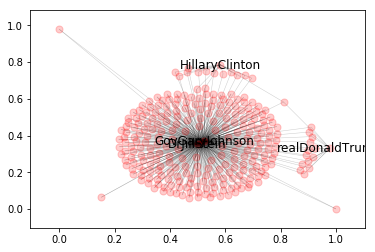

In [31]:
def main():
    """ Main method. You should not modify this. """
    twitter = get_twitter()
    screen_names = read_screen_names('candidates.txt')
    print('Established Twitter connection.')
    print('Read screen names: %s' % screen_names)
    users = sorted(get_users(twitter, screen_names), key=lambda x: x['screen_name'])
    print('found %d users with screen_names %s' %
          (len(users), str([u['screen_name'] for u in users])))
    add_all_friends(twitter, users)
    print('Friends per candidate:')
    print_num_friends(users)
    friend_counts = count_friends(users)
    print('Most common friends:\n%s' % str(friend_counts.most_common(5)))
    print('Friend Overlap:\n%s' % str(friend_overlap(users)))
    print('User followed by Hillary and Donald: %s' % followed_by_hillary_and_donald(users, twitter))

    graph = create_graph(users, friend_counts)
    print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))
    draw_network(graph, users, 'network.png')
    print('network drawn to network.png')


if __name__ == '__main__':
    main()